# Mean Shift

Mean Shift Algorithm Implementation using speedup (Attraction Basin) in LUV color space for image segmentation.
We'll be using `numba` python package for potential speedup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import imageio.v3 as iio
import random
from scipy.spatial.distance import euclidean, cdist
import os
from skimage.color import rgb2luv, luv2rgb
from tqdm.notebook import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
class MeanShift:
    def __init__(self, file_path, radius, grayscale=True, c=2):
        """
            Mean Shift Algorithm
            params:
            -------
                * file_path : path of image file
                * radius : parameter controlling the radius/ bandwidth to search
        """
        self.__cmap = self.__make_label_colormap()
        self.__img = None
        if not os.path.exists(file_path):
            raise Exception("Invalid Path. Does not Exist")
        self.__img = iio.imread(file_path)
        if grayscale == True:
            self.cmap = 'gray'
        else:
            self.cmap = "viridis"
        self.__radius = radius
        self.__search_path_rad = self.__radius / c

    def __make_label_colormap(self):
        """
            Create a color map for visualizing the labels themselves, such that the segment boundaries become more visible, unlike
            in the visualization using the cluster peak colors.
        """
        rng = np.random.RandomState(2)
        values = np.linspace(0, 1, 30)
        colors = plt.cm.get_cmap('hsv')(values)
        rng.shuffle(colors)
        return matplotlib.colors.ListedColormap(colors)
    
    def __find_peak(self, query_idx):
        """
            Helper Function which for each query point finds a peak as well as set of points which lie withing search path radius
        """   
        # Compute distance of given query point to all other points
        dist = cdist([self.__img[query_idx]], self.__img)[0]
        
        # Define arrays indicating for the given query point p, what points belongs within the search window and withing search path
        is_near_search_path = np.zeros(self.__img.shape[0], dtype=np.bool_)
        peak = np.zeros((self.__img.shape[-1])) # Store the peak (5d array in this case)

        within_radius = dist<=self.__radius
        is_near_search_path[dist<=self.__search_path_rad] = True

        del dist
        d = None
        
        # Shift operation
        while(True):
            # Compute mean of points within given radius
            new_peak = np.mean(self.__img[within_radius], axis = 0)
            if euclidean(new_peak, peak) <= 0.1:
                # Convergence reached
                break
            # compute distance of new peak to the all other points
            d = cdist([new_peak], self.__img)[0]
            within_radius = d <= self.__radius
            is_near_search_path[d<=self.__search_path_rad] = True

            # shift and continue computing
            peak = new_peak
        
        return peak, is_near_search_path
    
    def __mean_shift(self):
        """
        Helper function executing mean shift operation
        """
        len_ = self.__img.shape[0]
        labels = np.full(len_, fill_value=-1, dtype=int)

        peaks = []
        half_rad = self.__radius / 2
        
        # For each and every data point call the find_peak function and check against threshold
        for idx in tqdm(range(self.__img.shape[0])):
            if labels[idx] != -1:
                # Peak already assigned
                continue
            peak, is_near_search_path = self.__find_peak(idx)
            
            # Check threshold
            for ix, existing_peak in enumerate(peaks):
                if euclidean(existing_peak, peak) <= half_rad:
                    # assign the same label
                    labels[idx] = ix
                    
                    # Assign all seach path points to the same idx
                    labels[is_near_search_path] = ix
                    break
            else:
                # New peak discovered
                peak_idx = len(peaks)
                labels[idx] = peak_idx
                
                # Assign all seach path points to the new idx
                labels[is_near_search_path] = peak_idx
                peaks.append(peak)
                
                # Assign all points within radius distance from the peak their new lable
                condition = (labels!=-1)&(cdist([peak], self.__img)[0]<=self.__radius)
                labels[condition] = peak_idx
        
        peaks = np.array(peaks)
        return peaks, labels

    def run(self):
        # Convert image to LUV Color space
        self.__img = rgb2luv(self.__img)
        original_shape = self.__img.shape
        
        # Add spatial information to the image
        # Generate the same value in a given row for all x and alternate for y
        x_vals = np.array([ [val]*self.__img.shape[1] for val in range(self.__img.shape[0]) ])
        y_vals = np.array([ list(range(self.__img.shape[1])) for _ in range(self.__img.shape[0]) ])
        xy = np.stack([x_vals, y_vals], axis=-1)
        
        # Concatenate this to form an image of dimension H x W x 5
        self.__img = np.dstack((self.__img, xy))
        
        # Unfold into a 2d matrix so that we compute pairwise distances
        # New image matrix size : (H*W) x 5
        self.__img = self.__img.reshape((-1,5)).astype(np.float16)
        # # Shuffle pixels : To allow potential faster convergence instead of processing pixels in the same order
        # np.random.shuffle(self.__img)
        peaks, labels = self.__mean_shift()
        
        segmented_im = [peaks[lab] for lab in labels]
        segmented_im = np.array(segmented_im)
        # Remove the spatial information
        segmented_im = segmented_im[:, :3].reshape(original_shape)
        
        ## Convert image back to RGB Space
        segmented_im = luv2rgb(segmented_im)#.astype(np.uint8)

        fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 5))
        fig.suptitle(f'Mean Shift Clustering', fontsize=14)
        axes[0].set_title('Mean Shift Clustered Image')
        axes[0].imshow(segmented_im, vmin=0, vmax=1, cmap='viridis')

        axes[1].set_title('Labels (LUV+pos)')
        axes[1].imshow(labels.reshape(original_shape[:2]), cmap=self.__cmap)

In [4]:
ms_model = MeanShift("./data/toucan.jpg", radius=30, grayscale=False)

  0%|          | 0/262144 [00:00<?, ?it/s]

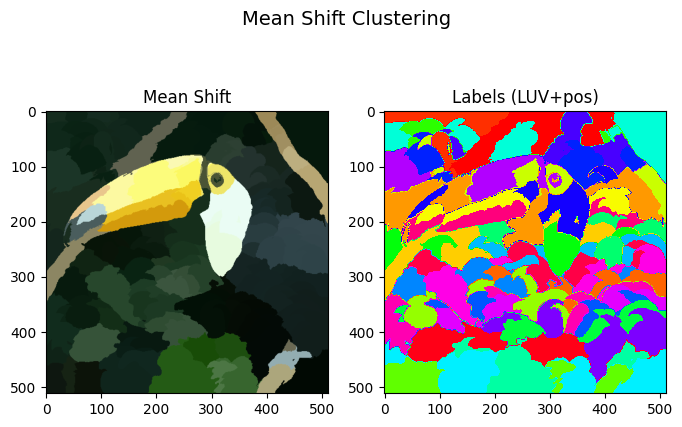

In [5]:
ms_model.run()